# Modeling reproduction rate based on government measures in effect

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# see all columns at once with scrolling
pd.set_option('display.max_columns', 200, 'display.max_rows', 100)

## Data
Create a table with

| Country | Date      | IndoorOver100 | MassGatherAll | StayHomeOrderPartial | ... | reproduction_rate |
|---------|-----------|---------------|---------------|----------------------|-----|-------------------|
| Austria | 3-10-2020 | 1             | 0             | 0                    |     | 1.5               |
| UK      | 1-2-2020  | 0             | 0             | 1                    |     | 0.8               |
| UK      | 2-4-2020  | 1             | 1             | 1                    |     | 0.2               |

In [100]:
TAU_RANGE = 35
owid = pd.read_csv('./data/1_owid/owid-covid-data.csv')
eu_response = pd.read_csv('./data/2_ecdc/country_response_measures.csv')

# df is the final dataset to use
df = owid.loc[:,["location","date","reproduction_rate",'population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand','life_expectancy', 'human_development_index']]

# reproduction_i is the reproduction rate after i days.
# for i in range(1,TAU_RANGE):
#     df['reproduction_'+str(i)] = df.groupby('location')['reproduction_rate'].shift(-i)

In [101]:
# only keep rows in df that match to a country in eu_response
df = df[[x in eu_response["Country"].unique() for x in df["location"]]]

# adding a column of all ones for beta_avg
# try:
#     df.insert(len(df.columns), "beta_avg", 1)
# except ValueError:  # ValueError thrown if df already has that column
#     pass

# initialize a column for each country type with all 0s
# for country in eu_response["Country"].unique():
#     try:
#         df.insert(len(df.columns), country, 0)
#     except ValueError:  # ValueError thrown if df already has that column
#         pass
# # set the corresponding country to 1
# for _, row in df.iterrows():
#     df.loc[ df["location"] == row["location"] , row["location"]] = 1


# initialize a column for each response type with all 0s
for response in eu_response["Response_measure"].unique():
    try:
        df.insert(len(df.columns), response, 0)
    except ValueError:  # ValueError thrown if df already has that column
        pass
for _, row in eu_response.iterrows():
    df.loc[ ( df["location"] == row["Country"] ) & ( df["date"] >= row["date_start"] ) & ( df["date"] < row["date_end"] ), row["Response_measure"]] = 1

In [102]:
# time from 2020-3-24 
df = df[pd.to_datetime(df.date) >= pd.to_datetime('2020-03-24')]
df['t'] = pd.to_numeric((pd.to_datetime(df.date)-pd.to_datetime('2020-03-24')).dt.days, downcast='float')
df['t2'] = df['t']**2
df['t3'] = df['t']**3
df['t4'] = df['t']**4
df['t5'] = df['t']**5

# onehot encode country data
df = pd.concat([df,pd.get_dummies(df.location)],axis=1)

# drop old non-numerical location and date
df = df.drop(['location','date'],axis=1)
df = df.dropna()
df.head()

,reproduction_rate,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index,AdaptationOfWorkplace,BanOnAllEvents,ClosDaycare,ClosDaycarePartial,ClosHigh,ClosPrim,ClosPrimPartial,ClosPubAny,ClosPubAnyPartial,ClosSec,ClosSecPartial,EntertainmentVenues,GymsSportsCentres,HotelsOtherAccommodation,IndoorOver100,IndoorOver1000,MasksMandatoryAllSpaces,MasksMandatoryClosedSpaces,MasksMandatoryClosedSpacesPartial,MasksVoluntaryClosedSpacesPartial,MassGather50,MassGatherAll,NonEssentialShops,NonEssentialShopsPartial,OutdoorOver1000,OutdoorOver50,OutdoorOver500,PlaceOfWorship,PlaceOfWorshipPartial,PrivateGatheringRestrictions,RestaurantsCafes,SocialCircle,StayHomeGen,StayHomeOrder,StayHomeOrderPartial,Teleworking,EntertainmentVenuesPartial,GymsSportsCentresPartial,IndoorOver500,MasksVoluntaryAllSpaces,MasksVoluntaryAllSpacesPartial,RestaurantsCafesPartial,StayHomeGenPartial,TeleworkingPartial,BanOnAllEventsPartial,ClosHighPartial,MassGather50Partial,MassGatherAllPartial,PrivateGatheringRestrictionsPartial,AdaptationOfWorkplacePartial,ClosureOfPublicTransport,StayHomeRiskG,HotelsOtherAccommodationPartial,IndoorOver50,OutdoorOver100,WorkplaceClosures,WorkplaceClosuresPartial,MasksMandatoryAllSpacesPartial,MasksVoluntaryClosedSpaces,StayHomeRiskGPartial,RegionalStayHomeOrderPartial,SocialCirclePartial,RegionalStayHomeOrder,ClosureOfPublicTransportPartial,t,t2,t3,t4,t5,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czechia,Denmark,Estonia,Finland,France,Germany,Greece,Hungary,Iceland,Ireland,Italy,Latvia,Liechtenstein,Lithuania,Luxembourg,Malta,Netherlands,Norway,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden,Switzerland,United Kingdom
2852,1.98,9006400.0,106.749,44.4,19.202,13.748,45436.686,145.183,6.35,28.4,30.9,7.37,81.54,0.908,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2853,1.82,9006400.0,106.749,44.4,19.202,13.748,45436.686,145.183,6.35,28.4,30.9,7.37,81.54,0.908,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2854,1.75,9006400.0,106.749,44.4,19.202,13.748,45436.686,145.183,6.35,28.4,30.9,7.37,81.54,0.908,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,4.0,8.0,16.0,32.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2855,1.57,9006400.0,106.749,44.4,19.202,13.748,45436.686,145.183,6.35,28.4,30.9,7.37,81.54,0.908,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,9.0,27.0,81.0,243.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2856,1.42,9006400.0,106.749,44.4,19.202,13.748,45436.686,145.183,6.35,28.4,30.9,7.37,81.54,0.908,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,16.0,64.0,256.0,1024.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Models

In [103]:
from sklearn.model_selection import train_test_split

# prepare data and divide train & test set
train, test = train_test_split(df, test_size=0.2, random_state=42)

## Linear Model
We perform OLS with each of the categories of responses as inputs (1 if active, 0 if not) to predict reproductive rate on that day (may have to shift reproductive rate by $\tau$ days)

The categories with largest negative coefficients are the most impactful (they reduce the reproductive rate the most)

In [21]:
from sklearn.linear_model import LinearRegression

In [7]:
Xtrain = train[eu_response["Response_measure"].unique()]
Xtest = test[eu_response["Response_measure"].unique()]
train_score = []
test_score = []
for i in range(0,TAU_RANGE):    
    if i == 0:
        Ytrain = train["reproduction_rate"]
        Ytest = test["reproduction_rate"]
    else:
        Ytrain = train["reproduction_"+str(i)]
        Ytest = test["reproduction_"+str(i)]
    linear_regressor = LinearRegression()
    linear_regressor.fit(Xtrain, Ytrain)
    train_score = train_score + [linear_regressor.score(Xtrain,Ytrain)]
    test_score = test_score + [linear_regressor.score(Xtest,Ytest)]

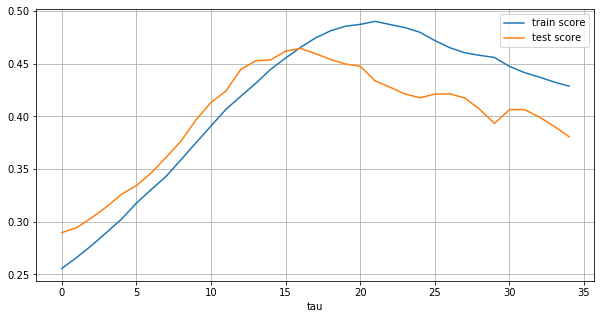

In [8]:
score_by_tau = pd.DataFrame({'tau':range(0,TAU_RANGE),'train score':train_score,'test score':test_score})
score_by_tau.set_index('tau').plot(figsize=(10,5), grid=True)

In [ ]:
train_score

In [ ]:
test_score

In [ ]:
coefficients = dict(zip(eu_response["Response_measure"].unique(), linear_regressor.coef_))
plt.figure(figsize=(6,12))
plt.barh(y = list(coefficients.keys()), width = coefficients.values())
plt.title("Coefficients $\\beta$ for each response_measure")

## Keras Sequential Model

Using df with more cols from owid

In [104]:
from keras.layers import Dense, Activation
from keras.models import Sequential

In [105]:
from sklearn.metrics import mean_squared_error
# RMSE metric
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

In [171]:
# create X and y for train and test
feature_columns = ['population',    # cols from owid in df except reproduction_rate (y variable), location, and date
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand','life_expectancy', 'human_development_index',
       't', 't2', 't3', 't4', 't5']

response_columns = list(eu_response["Response_measure"].unique())   # one-hot cols for each response type

country_cols = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia','Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece','Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands','Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia','Spain', 'Sweden', 'Switzerland', 'United Kingdom'] # European countries except Liechtenstein
assert len(country_cols) == 31  # there should be 31 country columns 

# x_cols = response_columns # just reponse cols for testing
x_cols = feature_columns + response_columns + country_cols
y_cols = ["reproduction_rate"]

X_train = train[x_cols]
y_train = train[y_cols]

X_test = test[x_cols]
y_test = test[y_cols]


# Use df instead of pre-split train and test dataframes
# X_train = df[x_cols]
# y_train = df["reproduction_rate"]


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6696, 113)
(1674, 113)
(6696, 1)
(1674, 1)


In [203]:
feature_columns

['population',
 'population_density',
 'median_age',
 'aged_65_older',
 'aged_70_older',
 'gdp_per_capita',
 'cardiovasc_death_rate',
 'diabetes_prevalence',
 'female_smokers',
 'male_smokers',
 'hospital_beds_per_thousand',
 'life_expectancy',
 'human_development_index',
 't',
 't2',
 't3',
 't4',
 't5']

In [172]:
# Standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [173]:
X_train_scaled.head()

,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index,t,t2,t3,t4,t5,AdaptationOfWorkplace,BanOnAllEvents,ClosDaycare,ClosDaycarePartial,ClosHigh,ClosPrim,ClosPrimPartial,ClosPubAny,ClosPubAnyPartial,ClosSec,ClosSecPartial,EntertainmentVenues,GymsSportsCentres,HotelsOtherAccommodation,IndoorOver100,IndoorOver1000,MasksMandatoryAllSpaces,MasksMandatoryClosedSpaces,MasksMandatoryClosedSpacesPartial,MasksVoluntaryClosedSpacesPartial,MassGather50,MassGatherAll,NonEssentialShops,NonEssentialShopsPartial,OutdoorOver1000,OutdoorOver50,OutdoorOver500,PlaceOfWorship,PlaceOfWorshipPartial,PrivateGatheringRestrictions,RestaurantsCafes,SocialCircle,StayHomeGen,StayHomeOrder,StayHomeOrderPartial,Teleworking,EntertainmentVenuesPartial,GymsSportsCentresPartial,IndoorOver500,MasksVoluntaryAllSpaces,MasksVoluntaryAllSpacesPartial,RestaurantsCafesPartial,StayHomeGenPartial,TeleworkingPartial,BanOnAllEventsPartial,ClosHighPartial,MassGather50Partial,MassGatherAllPartial,PrivateGatheringRestrictionsPartial,AdaptationOfWorkplacePartial,ClosureOfPublicTransport,StayHomeRiskG,HotelsOtherAccommodationPartial,IndoorOver50,OutdoorOver100,WorkplaceClosures,WorkplaceClosuresPartial,MasksMandatoryAllSpacesPartial,MasksVoluntaryClosedSpaces,StayHomeRiskGPartial,RegionalStayHomeOrderPartial,SocialCirclePartial,RegionalStayHomeOrder,ClosureOfPublicTransportPartial,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czechia,Denmark,Estonia,Finland,France,Germany,Greece,Hungary,Iceland,Ireland,Italy,Latvia,Lithuania,Luxembourg,Malta,Netherlands,Norway,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden,Switzerland,United Kingdom
0,-0.296026,-0.342842,1.045767,0.765187,1.077290,-0.938216,-0.096613,-0.847975,2.337972,2.121758,-0.336846,0.637730,-0.495818,0.376493,0.122778,-0.088547,-0.236624,-0.330926,-0.132191,-0.39279,-0.460852,-0.270645,-0.558951,-0.619020,-0.300331,-0.391269,2.211149,-0.614406,-0.365998,-0.519022,-0.489429,-0.249365,-0.313728,-0.321987,-0.294680,2.557448,-0.267454,-0.094284,-0.518095,-0.639834,-0.418755,-0.256715,-0.372786,-0.273179,-0.355155,-0.323679,-0.244257,-0.446251,-0.516935,0.0,-0.238366,-0.322552,-0.14126,-0.327327,2.090380,-0.36626,-0.297068,-0.241845,-0.162854,2.493094,-0.161399,-0.192807,4.83209,-0.336202,3.562759,2.127147,-0.124991,-0.168563,-0.095884,-0.288348,-0.164777,-0.347375,-0.253394,-0.158452,-0.095087,3.716740,-0.209293,-0.054734,-0.082255,0.0,-0.079448,-0.172275,-0.179051,-0.182137,-0.183010,-0.182574,-0.180379,-0.180379,-0.18301,-0.184747,-0.182137,-0.182574,-0.180820,5.464169,-0.18301,-0.188177,-0.180379,-0.189026,-0.176368,-0.182137,-0.182574,-0.18082,-0.182574,-0.180379,-0.186897,-0.181699,-0.183446,-0.186039,-0.182137,-0.184747,-0.182137,-0.18126,-0.181699
1,-0.449170,-0.414433,0.803311,0.939873,0.438530,-1.327822,2.653248,-0.127586,1.291941,1.304137,1.591309,-2.157452,-1.945443,-0.125600,-0.396799,-0.528215,-0.572730,-0.572795,-0.132191,-0.39279,-0.460852,-0.270645,-0.558951,1.615458,-0.300331,-0.391269,-0.452253,1.627589,-0.365998,-0.519022,-0.489429,-0.249365,-0.313728,-0.321987,3.393507,-0.391015,-0.267454,-0.094284,-0.518095,-0.639834,-0.418755,-0.256715,-0.372786,-0.273179,-0.355155,-0.323679,-0.244257,-0.446251,-0.516935,0.0,-0.238366,-0.322552,-0.14126,-0.327327,-0.478382,-0.36626,-0.297068,-0.241845,-0.162854,-0.401108,-0.161399,-0.192807,-0.20695,2.974401,-0.280681,-0.470113,-0.124991,-0.168563,-0.095884,-0.288348,-0.164777,-0.347375,-0.253394,-0.158452,-0.095087,-0.269053,-0.209293,-0.054734,-0.082255,0.0,-0.079448,-0.172275,-0.179051,-0.182137,5.464169,-0.182574,-0.180379,-0.180379,-0.18301,-0.184747,-0.182137,-0.182574,-0.180820,-0.183010,-0.18301,-0.188177,-0.180379,-0.189026,-0.176368,-0.182137,-0.182574,-0.18082,-0.182574,-0.180379,-0.186897,-0.181699,-0.183446,-0.186039,-0.182137,-0.184747,-0.182137,-0.18126,-0.181699
2,2.937353,0.257839,1.57

In [185]:
%%time
# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(128, activation = 'relu', input_dim = X_train.shape[1]))

# Adding the second hidden layer
model.add(Dense(units = 128, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 128, activation = 'relu'))

# Adding the output layer

model.add(Dense(units = 1))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train_scaled, y_train, batch_size = 64, epochs = 1000, validation_split=0.2)

Epoch 1/1000
84/84 [==============================] - 0s 4ms/step - loss: 0.1134 - val_loss: 0.0422
Epoch 2/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.0413 - val_loss: 0.0406
Epoch 3/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.0384 - val_loss: 0.0369
Epoch 4/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.0365 - val_loss: 0.0396
Epoch 5/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.0371 - val_loss: 0.0348
Epoch 6/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.0360 - val_loss: 0.0334
Epoch 7/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0340
Epoch 8/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0385
Epoch 9/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0341
Epoch 10/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0344

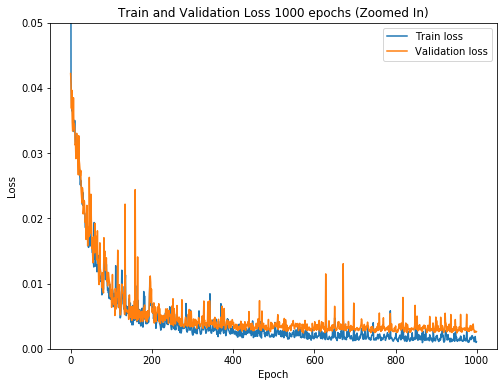

In [202]:
plt.figure(figsize=(8,6))

# Zoom in
axes = plt.gca()
axes.set_ylim([0,0.05])

plt.plot(history.history["loss"], label = "Train loss")
plt.plot(history.history["val_loss"], label = "Validation loss")
plt.legend()
plt.title("Train and Validation Loss 1000 epochs (Zoomed In)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("loss_1000_zoomed.png")

In [184]:
print("RMSE: " + str(rmse(y_test, model.predict(X_test_scaled))))

RMSE: 0.062207300574259994
